In [1]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from tensorflow.keras.layers import Dropout
from keras import backend as K 
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from random import randint, random

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
image_size = (208,208)
batch_size = 32

In [3]:
def correct_data_car(image_size):
    a,b = image_size
    boxes = []
    car_class = []
    df = pd.read_csv('_annotations.csv') 
    for x1,y1,x2,y2 in zip(df['xmin'].apply(lambda x: int(x) / 416 * a), list(df['ymin'].apply(lambda x: int(x) / 416 * b)), 
                       list(df['xmax'].apply(lambda x: int(x) / 416 * a)), list(df['ymax'].apply(lambda x: int(x) / 416 * b))):
        arr = [int(x1), int(y1), int(x2), int(y2)]
        boxes.append(arr)
    return df, boxes

In [4]:
def correct_data_accidents(image_size):
    boxes = []
    a,b = image_size
    df = pd.read_csv('accidents.csv') 
    for x1,y1,x2,y2 in zip(list(df['xmin'].apply(lambda x: int(x) * (a / 1280))), list(df['ymin'].apply(lambda x: int(x) * (b / 720))), 
                           list(df['xmax'].apply(lambda x: int(x) * (a / 1280))), list(df['ymax'].apply(lambda x: int(x) * (b / 720)))):
        arr = [int(x1), int(y1), int(x2), int(y2)]
        boxes.append(arr)
    return df, boxes

In [5]:
def data_metrics(df,image_size):
    images = []
    for index, i in df.iterrows():
        image = cv2.imread(index)
        image = cv2.resize(image,image_size)
        images.append(image)
    return images

In [6]:
def classification(df):
    train_class = []
    for index, row in df.iterrows():
        if row['class'] == 'vehicle' or row['class'] == 'motorbike':
            train_class.append([0,1])
        elif row['class'] =='accidents':
            train_class.append([1,0])
        else: 
            train_class.append([1,0,0])
    return np.array(train_class)

In [7]:
def data_img(images, coordinates, image_size):
    scarled_region_class = []
    scarled_region_loc = []
    a,b = image_size
    for image, coords in zip(images, coordinates):
        x, y, w, h = coords
        if x + y + w + h != 0:
            car_region = image[y:h, x:w]
            scarled_region_class.append(cv2.resize(car_region, image_size))
            #scarled_region_class.append(cv2.resize(image[y:h-y,x:w-x], image_size))
            scarled_region_loc.append(cv2.resize(image, image_size))
        else:
            scarled_region_class.append(cv2.resize(image, image_size))
            scarled_region_loc.append(cv2.resize(image, image_size))
    return np.array(scarled_region_loc), np.array(coordinates),np.array(scarled_region_class)#, np.array(region)
        
    

In [8]:
def data_test_fun(images, coordinates, image_size):
    scaled_regions = []
    labels = []
    for image, coords in zip(images, coordinates):
        x, y, w, h = coords
        if x + y + w + h != -4:
            scaled_region = cv2.resize(image, image_size)
            scaled_regions.append(scaled_region)
        else:
            #image = np.array(image)
            scaled_regions.append(cv2.resize(image, image_size))
    return np.array(scaled_regions), np.array(coordinates)

In [9]:
def _data_car(df,image_size):
    boxes = []
    a,b = image_size
    for height, width, x1, y1, x2, y2 in zip(df['height'], df['width'], list(df['xmin'].apply(lambda x: int(x) / 416 * a)), list(df['ymin'].apply(lambda x: int(x) / 416 * a)), 
               list(df['xmax'].apply(lambda x: int(x) / 416 * a)), list(df['ymax'].apply(lambda x: int(x) / 416 * a))):
        if height == 0 and width ==0:
            boxes.append([0,0,0,0])
        else:
            arr = [int(x1), int(y1), int(x2), int(y2)]
            boxes.append(arr)
    return boxes

In [10]:
def _data_acc(df,image_size):
    boxes = []
    a,b = image_size
    for x1,y1,x2,y2 in zip(list(df['xmin'].apply(lambda x: int(x) * (a / 1280))), list(df['ymin'].apply(lambda x: int(x) * (b / 720))), 
                           list(df['xmax'].apply(lambda x: int(x) * (a / 1280))), list(df['ymax'].apply(lambda x: int(x) * (b / 720)))):
        arr = [int(x1), int(y1), int(x2), int(y2)]
        boxes.append(arr)
    return boxes

In [11]:
# df_trash = pd.DataFrame({'filename': os.listdir('DataSet_cars_valid\\1_trash-')})
# df_trash = df_trash.set_index('filename')
# df_trash = df_trash.astype(str)

In [12]:
#аварии
# %cd data/train/Accident — копия
# df_accidents, boxes_accidents = correct_data_accidents(image_size)
# df_accidents = df_accidents.set_index('filename')
# del df_accidents['Unnamed: 0']
# df_accidents = df_accidents.astype(str)
# boxes_accidents = _data_acc(df_accidents, image_size)
# image_acc = data_metrics(df_accidents,image_size)
# %cd ../../..

In [13]:
# %cd DataSet_cars_valid/val
# df_car, boxes_car = correct_data_car(image_size)
# df_car = df_car.set_index('filename')
# train = pd.concat([df_car, df_trash])
# train = train.fillna(0)
# boxes_car = _data_car(train,image_size)
# train = train.sort_values(by = 'filename')
# train = pd.concat([train,df_accidents])
# #train = train.set_index('filename')
# boxes_train = boxes_car + boxes_accidents
# image_train, boxes_train = data_metrics(train,image_size,boxes_train)
# %cd ../..

In [14]:
#классификация
# %cd DataSet_cars_valid/val
# df_car, boxes_car = correct_data_car(image_size)
# train = df_car.set_index('filename')
# #train = pd.concat([df_car, df_trash])
# #train = train.fillna(0)
# boxes_car = _data_car(train,image_size)
# train = train.sort_values(by = 'filename')
# train = pd.concat([train,df_accidents])
# #train = train.set_index('filename')
# boxes_train = boxes_car + boxes_accidents
# image_train = data_metrics(train,image_size)
# %cd ../..

In [15]:
%cd DataSet_cars_train/train
df_car, boxes_car = correct_data_car(image_size)
train = df_car.set_index('filename')
boxes_train = _data_car(train,image_size)
train = train.sort_values(by = 'filename')
image_train = data_metrics(train,image_size)
%cd ../..

C:\Users\Matvey\Проект\Project\DataSet_cars_train\train
C:\Users\Matvey\Проект\Project


In [27]:
region_train, image_coodrs, scarled_region = data_img(image_train, boxes_train, image_size)

In [17]:
#проверка
len(image_train)

27241

In [63]:
for i, image in enumerate(region_train):
    if i % 100 == 0: print(i)
    x, y, w, h = image_coodrs[i]
    if x+y+w+h != 0:
        cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

0


KeyboardInterrupt: 

In [28]:
class_train = classification(train)

In [29]:
#Загрузить модель NasNetMobile, обязательно исключив вершину для трансферного обучения
N_mobile = tf.keras.applications.NASNetMobile( input_tensor = Input(
    shape=(208,208,3)), 
    include_top=False, 
    weights='imagenet')

In [30]:
def create_model():

    # Freeze the whole model
    N_mobile.trainable = False
    
    # Start by taking the output feature maps from NASNETMobile
    base_model_output = N_mobile.output
    
    # Convert to a single-dimensional vector by Global Average Pooling.

    # We could also use Flatten()(x) but GAP is more effective, it reduces 
    # Parameters and controls overfitting.
    flattened_output = GlobalAveragePooling2D()(base_model_output)
        # Create Our Localization Head, final layer contains 4 nodes for x1,y1,x2,y2
    # Respectively.
    box_output = Dense(256, activation="relu")(flattened_output)
    box_output = Dense(128, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(64, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(32, activation="relu")(box_output)
    box_predictions = Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)

    # Now combine the two heads
    model = Model(inputs=N_mobile.input, outputs= box_predictions)
    return model
loc_model = create_model()

# We will be using early stopping to stop the model if total val loss does not
# Decrease by 0.001 in 40 epochs
stop = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40, 
                    restore_best_weights = True
                     )

# Change the learning rate according to number of epochs to boost learning
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002, 
                              patience = 30, min_lr = 1e-7, verbose = 1)

# Initialize Optimizer
opt = SGD(lr = 1e-3, momentum = 0.9)

# Compile the model with Adam optimizer
loc_model.compile(optimizer = opt, loss = 'mean_squared_error', 
    metrics = ['mse'])

C:\Users\Matvey\anaconda3\envs\tfod\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(208, 208, 3)),  # свёрточный слой (Conv2D(128) для классификации)
    #попробуй по 2-3 свёрточных слоя сделать
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(64, (3, 3), activation='relu'),  # свёрточный слой (Conv2D(128) для классификации)
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

#     Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой
#     MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
#     Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(128, (3, 3), activation='relu'),  # свёрточный слой (Conv2D(256) для классификации)
    MaxPooling2D((2, 2), strides=2),  # уменьшеи карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

#     Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой (Conv2D(512) для классификации)
#     MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
#     Dropout(0.2),  # отключение 20 процентов нейронов

    Flatten(),
    Dense(256, activation='relu'),  # обычные нейроны Dense(512)
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(128, activation='relu'),  # обычные нейроны Dense(256)
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(64, activation='relu'),  # обычные нейроны Dense(128)
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(4, activation='linear'),  # выходной слой (для классификации 2 нейрона и sigmoid)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [18]:
#Классификация
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Локализация


In [31]:
train_data, val_data, train_coords, val_coords,train_class, val_class, train_region, val_region = train_test_split(
    region_train, image_coodrs, class_train,scarled_region, test_size=0.2, random_state=42)

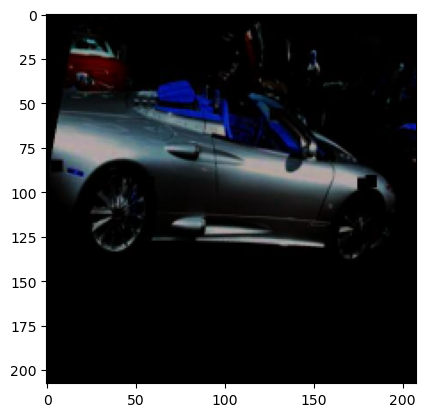

In [22]:
test = tf.convert_to_tensor(train_data[1])
plt.imshow(test, cmap='gray')
plt.show()

In [27]:
# train_class = np.array(train_class)
# val_class = np.array(val_class)

In [32]:
#классификация
#history = model.fit(train_region, train_class, epochs = 60, batch_size = batch_size, validation_data = (val_region, val_class))
#локализация
history = loc_model.fit(train_data, train_coords, epochs = 30, batch_size = 32, validation_data = (val_data, val_coords))

Epoch 1/30
681/681 [==============================] - ETA: 0s - loss: 19489.0039 - mse: 19489.0039

ResourceExhaustedError:  OOM when allocating tensor with shape[32,3,208,208] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_float_Cast}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_53588]

Function call stack:
test_function


In [29]:
history = model.fit(train_region, train_class, epochs = 60, batch_size = batch_size, validation_data = (val_region, val_class))

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'int\'>"})'})

In [176]:
model.save('class.h5')